# Retrieval Augmented Question & Answering with Amazon Bedrock using LangChain & Vector Search
> *This notebook should work well with the **`Data Science 3.0`** kernel in SageMaker Studio*

---

Previously, we used the Anthropic Claude model in Amazon Bedrock to demonstrate a basic Question Answering (QA) system, and learned the value of grounding a model with additional context before generating a response. In the previous notebook, we had to manually provide the model with relevant data and context ourselves. However, this approach is not fit for enterprise-level QA systems where there could be hundreds of thousands of large documents.

## Retrieval Augmented Generation (RAG)

We can improve upon this process by implementing an architecture called retrieval augmented generation (RAG). RAG retrieves data from outside the LLM's training data sources and augments the prompts by adding the relevant retrieved data as context. RAG extends the already powerful capabilities of LLMs to specific domains or an organization's internal knowledge base, without needing to retrain the model. It is a cost-effective approach to improving LLM output so it remains relevant, accurate, and useful in various contexts.

## Solution

In this notebook, we augment LLM responses to user queries by implementing RAG using context from external documents. First, we process documents and store these into a vector store. Next, we search the vector store using the user's question, and return relevant data as external context to the LLM. Finally, the LLM generates an answer to the user's question based on the new context provided.

We will walk through implementing the following two patterns: Question Answering (QA) and Conversational AI with conversation memory. 

Let’s break down the solution a little further. 

### Prepare documents for search
![Documents](./images/embeddings_lang.png)

First, the documents must be processed and then indexed in a vector store.
- Load the documents from our directory
- Process the documents by splitting them into smaller chunks
- Create a numerical vector representation of each chunk using an embeddings model
- Create an index using the chunks and the corresponding embeddings

### Respond to the user’s question
![Question](./images/chatbot_lang.png)

Once the vector store is indexed with documents and embeddings, we can search for text relevant to the question being asked. The relevant chunks are sent to the model as additional context, where the model will then generate the answer.
- Create an embedding of the input question
- Compare the question embedding with the embeddings in the index
- Fetch the (top N) relevant document chunks
- Add those chunks as part of the context in the prompt
- Send the prompt to the model under Amazon Bedrock
- Get the contextual answer based on the documents retrieved

Let's get started!

## Setup

In [1]:
import sys
import os
module_path = "../.."
sys.path.append(os.path.abspath(module_path))
from utils.environment_validation import validate_environment, validate_model_access
validate_environment()

Validating base environment
Base environment validated successfully


Validating lab environment from requirements.txt ✨

ENVIRONMENT STATUS
✅  langchain-aws==0.2.22 is installed
✅  langchain-community==0.3.23 is installed
✅  langchain-core==0.3.58 is installed
✅  langchain-text-splitters==0.3.8 is installed
✅  langgraph==0.4.1 is installed
✅  faiss-cpu>=1.7,<2 is installed
✅  opensearch-py==2.8.0 is installed
✅  docling==2.31.0 is installed
✅  pypdf==5.4.0 is installed
✅  rank-bm25==0.2.2 is installed

All required libraries are installed.🎉
You may proceed with the lab! 🚀

In [2]:
required_models = [
    "amazon.titan-embed-text-v1",
    "amazon.titan-embed-text-v2:0",
    "us.anthropic.claude-3-5-haiku-20241022-v1:0",
    "us.anthropic.claude-3-5-sonnet-20241022-v2:0",
    "amazon.rerank-v1:0"
]
validate_model_access(required_models)

MODEL ACCESS STATUS
✅  amazon.titan-embed-text-v1 is accessible
✅  amazon.titan-embed-text-v2:0 is accessible
✅  us.anthropic.claude-3-5-haiku-20241022-v1:0 is accessible
✅  us.anthropic.claude-3-5-sonnet-20241022-v2:0 is accessible
✅  amazon.rerank-v1:0 is accessible

All required models are accessible.🎉
You may proceed with the lab! 🚀

In [3]:
import json
import boto3
import warnings
from pathlib import Path
from rich import print as rprint
warnings.filterwarnings('ignore')


boto3_bedrock = boto3.client("bedrock-runtime")

## Configure LangChain

LangChain provides convenient integrations with Amazon Bedrock and other services like vector stores and retrievers. We begin with instantiating the large language model (LLM) and the embeddings model. We are using Anthropic Claude models for text generation and Amazon Titan Embeddings G1 - Text for text embedding.

Note: Amazon Bedrock offers a choice of high-performing foundation models (FMs). You can replace the value for `model_id` with one of the available [model IDs](https://docs.aws.amazon.com/bedrock/latest/userguide/model-ids.html) as follows. Some models have different requirements for inputs such as prompt format. As of this writing, all models are supported in the US West (Oregon, us-west-2) Region. If you are using another AWS Region, check the latest [model support by AWS Region](https://docs.aws.amazon.com/bedrock/latest/userguide/models-regions.html).

```python
llm = ChatBedrock(model_id="us.anthropic.claude-3-5-haiku-20241022-v1:0", ...)
```


In [4]:
from langchain_aws.embeddings import BedrockEmbeddings
from langchain_aws.chat_models import ChatBedrock
from langchain.load.dump import dumps

# Instantiate the LLM

model_id = "us.anthropic.claude-3-5-haiku-20241022-v1:0"

llm = ChatBedrock(
    model_id=model_id,
    model_kwargs={"max_tokens": 500}
)

# Instantiate the Amazon Titan Embeddings G1 - Text embeddings model
bedrock_embeddings = BedrockEmbeddings(
    client=boto3_bedrock,
    model_id="amazon.titan-embed-text-v2:0" # change this model ID to use another embeddings model
)

## Usecase Introduction - Model Risk and Model Governance Assistant
In this notebook we will learn the application of RAG through a practical example. The use case we will be working on is a Model Risk and Model Governance Assistant. This assistant will help users understand the risks associated with deploying machine learning models in production. The assistant will provide information on the following topics:
- Model Risk Management
- Model Governance
- Regulatory Compliance
- Model Monitoring
- Model Validation
- And more

We will use some publicly available regulatory guideline documents to serve as the source for our RAG solution. You can vew the documents in the `../data/model_risk` directory.

## Data Preparation
We will load the documents with the help of [PyPDF in LangChain](https://python.langchain.com/docs/modules/data_connection/document_loaders/pdf).

We will utilize a few different techniques when loading the documents that will help improve the retrieval quality.

#### Outline based splitting
By default LangChain's `PyPDFLoader` will break each document up into pages. We could then potentially use a chunking strategy such as `RecursiveCharacterTextSplitter` to further break down the pages into smaller chunks. 
However, this could lead to suboptimal results if the most relevant information we are looking for is split across multiple pages. Instead, we will split the documents into sections based on the documents own table of contents. The implementation for this approach is provided in the rag_utils.outline_parser module [(source)](./rag_utils/outline_parser.py).
Note that this approach only works on PDFs that contain a table of contents.


#### Parent Document Retriever
After we've loaded the document as individual sections, we will further split these sections by paragraphs using the [RecursiveCharacterTextSplitter](https://python.langchain.com/docs/modules/data_connection/document_transformers/recursive_text_splitter/). These are the chunks that will be used for embeddings, however during retrieval we'll utilize the [ParentDocumentRetriever](https://python.langchain.com/docs/modules/data_connection/retrievers/parent_document_retriever/) to retrieve the entire section that the chunk belongs to. This is done to ensure that the context provided to the model is as complete as possible.


In [5]:
from langchain.document_loaders import PyPDFLoader
from rag_utils.outline_parser import PyPDFOutlineParser

docs_path = Path("../data/model_risk")
doc_files = list(docs_path.glob("*.pdf"))

section_chunks = []

for doc_path in doc_files:
    loader = PyPDFLoader(file_path=doc_path.as_posix())
    loader.parser = PyPDFOutlineParser()
    sections = loader.load()
    for sec in sections:
        sec.metadata.update({"file": doc_path.name})
    
    section_chunks += sections
    

Found 9 bookmarks to process.
Found 52 bookmarks to process.


Each section chunk now contains a the contents and metadata associated with that section

Now let's test out our embedding model on a single section to see what an embedding looks like below. These embeddings could be generated for the entire corpus of documents and stored in a vector store for easy retrieval.

In [6]:
sample_embedding = bedrock_embeddings.embed_query(section_chunks[0].page_content)
modelId = bedrock_embeddings.model_id
rprint("Embedding model Id :", modelId)
rprint("Sample embedding of a document chunk: ", sample_embedding[:10])
rprint("Size of the embedding: ", len(sample_embedding))


Embedding model Id : amazon.titan-embed-text-v2:0

Sample embedding of a document chunk: 
[
    -0.05445801839232445,
    0.036640509963035583,
    0.01590735837817192,
    -0.010999615304172039,
    -0.02302771620452404,
    -0.01712311990559101,
    -0.023082245141267776,
    -0.028713496401906013,
    -0.010255202651023865,
    -0.002786779310554266
]

Size of the embedding:  1024

## Create the vector store
In this workshop we will use aa local vector store powered by [FAISS](https://faiss.ai/index.html) an open source library for efficient similarity search and clustering of vectors.

In [7]:
from langchain_community.vectorstores import FAISS, DistanceStrategy
from langchain_community.docstore.in_memory import InMemoryDocstore
import faiss
import datetime as dt

Now we are ready to ingest the documents into the vector store. This can be done easily using the [LangChain FAISS integration](https://python.langchain.com/docs/integrations/vectorstores/faiss/) which takes in the embeddings model and the documents to create the entire vector store.

In [8]:
vec_store_time_stamp = dt.datetime.now().strftime("%Y%m%d%H%M%S")

docstore = InMemoryDocstore()
index = faiss.IndexFlatL2(len(sample_embedding))
vector_db = FAISS(embedding_function=bedrock_embeddings, 
                  index=index, 
                  index_to_docstore_id={},
                  docstore=docstore, 
                  distance_strategy=DistanceStrategy.COSINE)

Next we build the `ParentDocumentRetriever` combining an FAISSbased vector store and key-value based `InMemoryStore`. The vector store will be used to find section segments that were generated using through splitting with the `RecursiveCharacterSplitter`. Each section segment will contain a key reference to the full section document. The key reference will be used to retrieve the entire section text. Note that the `InMemoryStore` is essentially a python dictionary, in production you would want to use a persistent store such as [DynamoDB](https://aws.amazon.com/dynamodb/).

In [10]:
from langchain.storage import InMemoryStore
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.retrievers import ParentDocumentRetriever
from io import BytesIO
import pickle
import time


child_splitter = RecursiveCharacterTextSplitter(
    separators=["\n", "\n\n"], chunk_size=2000, chunk_overlap=250
)

split_docs = child_splitter.split_documents(section_chunks)

vector_store_file = f"section_vector_store_{vec_store_time_stamp}.pkl"
local_vector_config = "local_config.json"

# if we previously ingested the docs we can reuse the existing index
if Path(local_vector_config).exists():
    vector_store_file = json.load(open(local_vector_config))["vector_store_file"]

    vector_db_buff = BytesIO(pickle.load(open(vector_store_file, "rb")))
    vector_db = FAISS.deserialize_from_bytes(
        serialized=vector_db_buff.read(),
        embeddings=bedrock_embeddings,
        allow_dangerous_deserialization=True,
    )

# ingest the document into the index
else:

    vector_db.add_documents(split_docs)
    pickle.dump(vector_db.serialize_to_bytes(), open(vector_store_file, "wb"))

    with open(local_vector_config, "w") as f:
        json.dump({"vector_store_file": vector_store_file}, f)

## Searching the vector store
Before we get into the parent document retrieval, let's first explore the various ways that we can query the vector store exclusively.

### Semantic search methods
[Semantic search](https://www.elastic.co/what-is/semantic-search) considers the context and intent of a query. Unlike traditional keyword based searches, semantic search utilize embedding that capture the meaning of the text. This allows for more relevant results to be returned. 

#### Approximate k-NN search
Standard k-NN search methods compute similarity using a brute-force approach that measures the nearest distance between a query and a number of points, which produces exact results. This works well in many applications. However, in the case of extremely large datasets with high dimensionality, this creates a scaling problem that reduces the efficiency of the search. Approximate k-NN search methods can overcome this by employing tools that restructure indexes more efficiently and reduce the dimensionality of searchable vectors. Using this approach requires a sacrifice in accuracy but increases search processing speeds appreciably.

Let's see a few examples of a semantic similarity search using FAISS

In [11]:
# Search query
query = "What can be considered a model?"

# Search for the 3 most relevant documents
results = vector_db.similarity_search(query, k=3)

rprint(dumps(results, pretty=True))

[
  {
    "lc": 1,
    "type": "constructor",
    "id": [
      "langchain",
      "schema",
      "document",
      "Document"
    ],
    "kwargs": {
      "id": "ba3fef67-4a99-4191-b1b2-f2463c3eaaa6",
      "metadata": {
        "section_title": "Background",
        "page_label": "1",
        "page_index": 3,
        "parent_section": "Introduction",
        "level": 3,
        "source": "../data/model_risk/pub-ch-model-risk.pdf",
        "page": 3,
        "start_page_index": 3,
        "end_page_index": 5,
        "file": "pub-ch-model-risk.pdf"
      },
      "page_content": "public disclosures. The definition of model also covers quantitative approaches whose inputs
are \npartially or wholly qualitative or based on expert judgment, provided that the output is quantitative \nin 
nature. (See note 1.) \nNote 1: While outside the scope of this guidance, more qualitative approaches used by 
banking organizations\u2014 i.e., those \nnot defined as models according to this guidance\u2014should also be 
subject to a rigorous control process. \nA model may combine assumptions, data, and hypotheses about the behavior 
of markets or \nindividuals, and process these inputs into quantitative estimates, forecasted outcomes, or 
\npredictions. \nSupervisory Guidance on Model Risk Management \nModels are simplified representations of 
real-world relationships among observed characteristics, \nvalues, and events. Simplification is inevitable, due to
the inherent complexity of those \nrelationships, but also intentional, to focus attention on particular aspects 
considered to be most \nimportant for a given model application. Model quality can be measured in many ways: 
precision, \naccuracy, discriminatory power, robustness, stability, and reliability, to name a few. Models are 
\nnever perfect, and the appropriate metrics of quality, and the effort that should be put into \nimproving 
quality, depend on the situation. For example, precision and accuracy are relevant for \nmodels that forecast 
future values, while discriminatory power applies to models that rank order \nrisks. In all situations, it is 
important to understand a model\u2019s capabilities and limitations given its \nsimplifications and assumptions. 
\nBecause assumptions are typically simplifications of the actual relationships between inputs \nand outputs, and 
hypotheses about behavior are imprecise, there is some uncertainty \nassociated with a model\u2019s estimate of the
outputs, resulting in prediction errors. \nVarious models may focus on discriminatory power or predictive power as 
measures of",
      "type": "Document"
    }
  },
  {
    "lc": 1,
    "type": "constructor",
    "id": [
      "langchain",
      "schema",
      "document",
      "Document"
    ],
    "kwargs": {
      "id": "1040f2f3-6a2b-4119-8223-54a1608a9418",
      "metadata": {
        "section_title": "III. Overview of Model Risk Management",
        "page_label": "3",
        "page_index": 2,
        "parent_section": "Contents",
        "level": 2,
        "source": "../data/model_risk/sr1107a1.pdf",
        "page": 2,
        "start_page_index": 2,
        "end_page_index": 3,
        "file": "sr1107a1.pdf"
      },
      "page_content": "Page 3 \nIII. OVERVIEW OF MODEL RISK MANAGEMENT \nFor the purposes of this document, the 
term model refers to a quantitative method, \nsystem, or approach that applies statistical, economic, financial, or
mathematical theories, \ntechniques, and assumptions to process input data into quantitative estimates. A model 
\nconsists of three components: an information input component, which delivers \nassumptions and data to the model;
a processing component, which transforms inputs into \nestimates; and a reporting component, which translates the 
estimates into useful business \ninformation. Models meeting this definition might be used for analyzing business 
\nstrategies, informing business decisions, identifying and measuring risks, valuing \nexposures, i

#### k-NN search with filters
 Filters can greatly reduce the number of vectors to be searched. In the example below we can filter on a specific document before running the k-NN search. This can be useful when you know the document that you are looking for.

In [12]:
query = "What are the acceptable model evaluation techniques?"

# filter on a specific document
pre_filter = {"file": "pub-ch-model-risk.pdf"}

# Pre-filter results
results = vector_db.similarity_search(
    query, 
    fetch_k=2,
    filter=pre_filter   
)

rprint(dumps(results, pretty=True))

[
  {
    "lc": 1,
    "type": "constructor",
    "id": [
      "langchain",
      "schema",
      "document",
      "Document"
    ],
    "kwargs": {
      "id": "fc510d77-db68-4f6e-8c9d-8fbc8f1de8fe",
      "metadata": {
        "section_title": "Testing",
        "page_label": "32",
        "page_index": 34,
        "parent_section": "Model Development and Implementation",
        "level": 5,
        "source": "../data/model_risk/pub-ch-model-risk.pdf",
        "page": 34,
        "start_page_index": 34,
        "end_page_index": 34,
        "file": "pub-ch-model-risk.pdf"
      },
      "page_content": "Version 1.0 \nTesting \nSupervisory Guidance on Model Risk Management \nAn integral part of 
model development is testing, in which the various components of a model and \nits overall functioning are 
evaluated to determine whether the model is performing as intended. \nModel testing includes checking the 
model\u2019s accuracy, demonstrating that the model is robust and \nstable, assessing potential limitations, and 
evaluating the model\u2019s behavior over a range of input \nvalues. It should also assess the impact of 
assumptions and identify situations where the model \nperforms poorly or becomes unreliable. Testing should be 
applied to actual circumstances under a \nvariety of market conditions, including scenarios that are outside the 
range of ordinary \nexpectations, and should encompass the variety of products or applications for which the model 
is \nintended. Extreme values for inputs should be evaluated to identify any boundaries of model \neffectiveness. 
The impact of model results on other models that rely on those results as inputs \nshould also be evaluated. 
Included in testing activities should be the purpose, design, and execution \nof test plans, summary results with 
commentary and evaluation, and detailed analysis of \ninformative samples. Testing activities should be 
appropriately documented. \nThe nature of testing and analysis will depend on the type of model and will be judged 
by different \ncriteria depending on the context. For example, the appropriate statistical tests depend on specific
\ndistributional assumptions and the purpose of the model. Furthermore, in many cases, statistical \ntests cannot 
unambiguously reject false hypotheses or accept true ones based on sample \ninformation. Different tests have 
different strengths and weaknesses under different conditions. \nAny single test is rarely sufficient, so banks 
should apply a variety of tests to develop a sound \nmodel. \nBanks should ensure that the development of the more 
judgmental and qualitative aspects of their",
      "type": "Document"
    }
  },
  {
    "lc": 1,
    "type": "constructor",
    "id": [
      "langchain",
      "schema",
      "document",
      "Document"
    ],
    "kwargs": {
      "id": "754b60d7-2563-4964-9fb9-196c7ce6aa89",
      "metadata": {
        "section_title": "Internal Control Questionnaire",
        "page_label": "84",
        "page_index": 86,
        "parent_section": "Examination Procedures",
        "level": 3,
        "source": "../data/model_risk/pub-ch-model-risk.pdf",
        "page": 86,
        "start_page_index": 86,
        "end_page_index": 104,
        "file": "pub-ch-model-risk.pdf"
      },
      "page_content": "sound and mathematically and statistically \ncorrect? \n10. Does the model development 
process include \ndocumented comparison of alternative theories \nand approaches? \n11. Does the development 
process produce \ndocumented evidence in support of all model \nchoices, including the overall theoretical 
\nconstruction, key assumptions, data, and specific \nmathematical calculations? \n12. Are algorithms, mathematical
formulas, computer \ncode, software, and IT systems implementing \nmodels subject to rigorous quality control and 
\nchange control processes to confirm that the \ncode is correct, that it cannot be altered except \nby approved 
parties, and that all chang

#### Spaces - similarity or distance measures

When we created the vector store above we sepcified cosine similarity `DistanceStrategy.COSINE` as our distance metric. This is one of the more commonly used metrics, however there are other options as well:

**Cosine similarity** – The cosine of the angle between two vectors in a vector space.

**Euclidean distance** – The straight-line distance between points.

**L1 (Manhattan) distance** – The sum of the differences of all of the vector components. L1 distance measures how many orthogonal city blocks you need to traverse from point A to point B.

**L-infinity (chessboard) distance** – The number of moves a King would make on an n-dimensional chessboard. It’s different than Euclidean distance on the diagonals—a diagonal step on a 2-dimensional chessboard is 1.41 Euclidean units away, but 2 L-infinity units away.

**Inner product** – The product of the magnitudes of two vectors and the cosine of the angle between them. Usually used for natural language processing (NLP) vector similarity.

We can specify the distance measure in the `space_type` parameter when we load our documents as seen below.

### Maximum marginal relevance search (MMR)
If you’d like to look up for some similar documents, but you’d also like to receive diverse results, MMR is a method you should consider. Maximal marginal relevance optimizes for similarity to query AND diversity among selected documents. It does this by finding the examples with the embeddings that have the greatest cosine similarity with the inputs, and then iteratively adding them while penalizing them for closeness to already selected examples.

In [13]:
# we fetch 10 results but then return the top 3 most diverse
results = vector_db.max_marginal_relevance_search(query, k=3, fetch_k=10)

rprint(dumps(results, pretty=True))

[
  {
    "lc": 1,
    "type": "constructor",
    "id": [
      "langchain",
      "schema",
      "document",
      "Document"
    ],
    "kwargs": {
      "id": "fc510d77-db68-4f6e-8c9d-8fbc8f1de8fe",
      "metadata": {
        "section_title": "Testing",
        "page_label": "32",
        "page_index": 34,
        "parent_section": "Model Development and Implementation",
        "level": 5,
        "source": "../data/model_risk/pub-ch-model-risk.pdf",
        "page": 34,
        "start_page_index": 34,
        "end_page_index": 34,
        "file": "pub-ch-model-risk.pdf"
      },
      "page_content": "Version 1.0 \nTesting \nSupervisory Guidance on Model Risk Management \nAn integral part of 
model development is testing, in which the various components of a model and \nits overall functioning are 
evaluated to determine whether the model is performing as intended. \nModel testing includes checking the 
model\u2019s accuracy, demonstrating that the model is robust and \nstable, assessing potential limitations, and 
evaluating the model\u2019s behavior over a range of input \nvalues. It should also assess the impact of 
assumptions and identify situations where the model \nperforms poorly or becomes unreliable. Testing should be 
applied to actual circumstances under a \nvariety of market conditions, including scenarios that are outside the 
range of ordinary \nexpectations, and should encompass the variety of products or applications for which the model 
is \nintended. Extreme values for inputs should be evaluated to identify any boundaries of model \neffectiveness. 
The impact of model results on other models that rely on those results as inputs \nshould also be evaluated. 
Included in testing activities should be the purpose, design, and execution \nof test plans, summary results with 
commentary and evaluation, and detailed analysis of \ninformative samples. Testing activities should be 
appropriately documented. \nThe nature of testing and analysis will depend on the type of model and will be judged 
by different \ncriteria depending on the context. For example, the appropriate statistical tests depend on specific
\ndistributional assumptions and the purpose of the model. Furthermore, in many cases, statistical \ntests cannot 
unambiguously reject false hypotheses or accept true ones based on sample \ninformation. Different tests have 
different strengths and weaknesses under different conditions. \nAny single test is rarely sufficient, so banks 
should apply a variety of tests to develop a sound \nmodel. \nBanks should ensure that the development of the more 
judgmental and qualitative aspects of their",
      "type": "Document"
    }
  },
  {
    "lc": 1,
    "type": "constructor",
    "id": [
      "langchain",
      "schema",
      "document",
      "Document"
    ],
    "kwargs": {
      "id": "ac6c7ba7-fd70-4ecf-87f9-cf8ec8c199a0",
      "metadata": {
        "section_title": "Quality of Model Risk Management",
        "page_label": "58",
        "page_index": 60,
        "parent_section": "Examination Procedures",
        "level": 3,
        "source": "../data/model_risk/pub-ch-model-risk.pdf",
        "page": 60,
        "start_page_index": 60,
        "end_page_index": 83,
        "file": "pub-ch-model-risk.pdf"
      },
      "page_content": "inputs. \n\u2022 includes the purpose, design, and execution of test plans, summary results 
with \ncommentary and evaluation, and detailed analysis of informative samples. \n\u2022 is appropriately 
documented, including documentation of adjustments made as well \nas the rationale and methodology. \n\u2022 
evaluates whether the development of judgmental or qualitative aspects of models \n(e.g., inputs, or adjustments to
outputs) are appropriate, conducted in a systematic \nmanner, and well-documented. \n\u2022 assesses whether 
third-party models are working as expected. \n\u2022 indicates third-party models\u2019 limitations and 
assumptions. \n5. Assess the appropr

## Orchestrating RAG using LangChain
Now that we can query our vector database for documents, we can retrieve data from outside of a large language model's training data sources and augment our prompts by adding the relevant retrieved data in context.

We can use LangChain to build applications that read data from stored internal documents and summarize them into conversational responses. We can create a Retrieval Augmented Generation (RAG) workflow that introduces new information to the language model during prompting. Implementing context-aware workflows like RAG reduces model hallucination and improves response accuracy.

### Single turn generative question answering

Let's start with a simple example where given a user query we retrieve relevant documents from the vector store and use the retrieved documents as context to generate a response.

We'll construct a prompt template that will take the user's question and the retrieved documents as context and generate a response.

In [14]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableParallel, RunnablePassthrough

template = """Answer the question based only on the following context. 
If the context does not provide sufficient information to answer the question, politely indicate that you are unable to assist. 
Only answer questions related to model risk and model governance.

<context>
{context}
</context>

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)
output_parser = StrOutputParser()

retriever = vector_db.as_retriever(k=5)

# in the first step we retrieve the context and pass through the input question
setup_and_retrieval = RunnableParallel(
    {"context": retriever, "question": RunnablePassthrough()}
    
)

# In the subsequent steps pass the context and question to the prompt, send the prompt to the llm and parse the output as a string
chain = setup_and_retrieval | prompt | llm | output_parser

Let’s try this with our earlier query:

In [15]:
query = "What can be considered a model?"

response = chain .invoke(query)
rprint(response)

Based on the context provided, a model can be defined as:

A quantitative method, system, or approach that:
1. Applies statistical, economic, financial, or mathematical theories, techniques, and assumptions
2. Processes input data into quantitative estimates
3. Consists of three components:
   - An information input component (delivers assumptions and data)
   - A processing component (transforms inputs into estimates)
   - A reporting component (translates estimates into useful business information)

The definition also includes quantitative approaches with:
- Inputs that are partially or wholly qualitative
- Inputs based on expert judgment
- As long as the output remains quantitative in nature

Models can be used for various purposes, such as:
- Analyzing business strategies
- Informing business decisions
- Identifying and measuring risks
- Valuing exposures, instruments, or positions
- Conducting stress testing
- Assessing capital adequacy
- Managing client assets
- Measuring compliance with internal limits
- Maintaining bank control apparatus
- Meeting financial or regulatory reporting requirements

The context emphasizes that models are simplified representations of real-world relationships, and they are never 
perfect, with quality measurable through metrics like precision, accuracy, discriminatory power, robustness, 
stability, and reliability.

In [16]:
query = "What are some acceptable model evaluation techniques?"

response = chain.invoke(query)
rprint(response)

Based on the provided context, here are some acceptable model evaluation techniques:

1. Checking the model's accuracy
2. Conducting sensitivity analysis over a range of input values
3. Demonstrating that the model is robust and stable
4. Assessing potential limitations
5. Evaluating the model's behavior under different conditions
6. Assessing the impact of assumptions
7. Identifying situations where the model performs poorly or becomes unreliable
8. Testing under various market conditions, including scenarios outside ordinary expectations
9. Evaluating extreme input values
10. Comparing alternative theories and approaches
11. Conducting critical analysis of model aspects
12. Analyzing the impact of key assumptions on model outputs
13. Verifying the relevance of data used to build the model
14. Performing ongoing monitoring, including process verification and benchmarking
15. Conducting outcomes analysis and back-testing

The context emphasizes that no single test is sufficient, and banks should apply a variety of tests to develop a 
sound model. The nature and specific techniques will depend on the type of model and its intended purpose.

In [17]:
from pydantic import BaseModel, Field
from typing import Annotated, Literal

from typing_extensions import TypedDict

from langchain_core.messages import HumanMessage, AIMessage

from langchain_aws.document_compressors.rerank import BedrockRerank
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import ContextualCompressionRetriever, EnsembleRetriever

from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [40]:
# used for lexical search
bm_25_retriever = BM25Retriever.from_documents(split_docs)
bm_25_retriever.k = 10

# used for semantic search
semantic_search_retriever = vector_db.as_retriever(search_kwargs={"k": 10})

# combine results from both retrievers
fusion_retriever = EnsembleRetriever(
    retrievers=[semantic_search_retriever, bm_25_retriever],
    weights=[0.5, 0.5]
)

bedrock_agent_runtime = boto3.client("bedrock-agent-runtime")

# reranker model
reranker = BedrockRerank(model_arn="arn:aws:bedrock:us-west-2::foundation-model/amazon.rerank-v1:0",
                         client=bedrock_agent_runtime,
                         region_name="us-west-2",
                         top_n=5)

# rerank the combined results from the fusion retriever
rerank_retriever = ContextualCompressionRetriever(
    base_compressor=reranker,
    base_retriever=fusion_retriever
)


In [64]:
class RAGState(TypedDict):
    messages: Annotated[list, add_messages]
    search_query: str
    context_summary: str
    search_results: list
    input_validated: bool


class InputValidator(BaseModel):
    input_validated: bool = Field(description="Whether the input is validated or not.")

class SearchQuery(BaseModel):
    query: str = Field(description="The search query to be used for retrieval.")
    context_summary: str = Field(description="The summary of the context of what is being asked.")

In [74]:
def validate_user_input(state: RAGState) -> Literal["formulate_search_query", "generate_answer"]:
    """
    Validate the user input to ensure it is a valid search query.
    """


    system_prompt = "You are the first line of defense for a chatbot that answers questions about model risk and model governance regulations. " \
                    "Your job is to validate the user's input and ensure it is relevant to the topic." \
                    "Use the available tool to validate the input and return the result." 
    
    validation_chain = llm.bind_tools(tools=[InputValidator]) | PydanticToolsParser(tools=[InputValidator])

    result = validation_chain.invoke([("system", system_prompt)] + state["messages"])[0]

    if result.input_validated:
        return "formulate_search_query"
    else:
        return "generate_answer"

In [75]:
def formulate_search_query(state: RAGState) -> RAGState:
    """Formulate the search query based on the user question."""
    
    query = state["messages"][-1].content
    
    prompt = "You are assisting with matters related to model risk and model governance. " \
            "You have access to a comprehensive database of regulations and best practices" \
            "as they relate to model risk and model governance. " \
            "Based on your expertise, help refine the user's question into a search query that can be used to retrieve relevant information." \
            "Given the prior interaction, please provide a search query that is relevant to the topic." \
            "Additionally, if the user's question is a follow-up question based on information from previous interactions, please take that into account." \
            "Please provide a brief summary of the context of what is being asked." \
            "Use the available tool to record the search query." \

    query_generation_chain  = llm.bind_tools([SearchQuery]) | PydanticToolsParser(tools=[SearchQuery])
    response = query_generation_chain.invoke([("system", prompt)] + state["messages"])
    query = response[0].query
    context_summary = response[0].context_summary
    return {"messages":[], "search_query": query, "search_results": [], "input_validated": True, "context_summary": context_summary}


In [76]:
def search(state: RAGState) -> RAGState:
    """Perform a search using the formulated search query."""
    
    search_query = state["search_query"]
    print("Search query: ", search_query)
    results = rerank_retriever.invoke(search_query)
    return {"messages":[], "search_query": search_query, "search_results": results}

In [82]:
def generate_answer(state: RAGState) -> RAGState:
    """Generate an answer based on the search results."""

    if state["input_validated"] == False:
        return {
            "messages": [AIMessage(content="I'm sorry but I cannot assist with that.")],
        }

    search_results = state["search_results"]
    if not search_results:
        return {
            "messages": [AIMessage(content="I'm sorry I could not find any relevant information.")],
        }

    search_results = "\n".join([doc.page_content for doc in search_results])
    question = state["messages"][-1].content
    context_summary = state["context_summary"]

    prompt = f"""Answer the question based only on the following context. 
    If the context does not provide sufficient information to answer the question, politely indicate that you are unable to assist. 
    Only answer questions related to model risk and model governance.

    <search_results>
    {search_results}
    </search_results>

    The context in which the question is being asked is:
    <context_summary>
    {context_summary}
    </context_summary>


    <question>
    {question}
    </question>
    """

    response_message = llm.invoke(prompt)
    return {
        "messages": [response_message],
        "search_query": state["search_query"],
        "search_results": state["search_results"],
        "input_validated": False,
        "context_summary": context_summary
    }

In [83]:
graph_builder = StateGraph(RAGState)

graph_builder.add_node("formulate_search_query", formulate_search_query)
graph_builder.add_node("search", search)
graph_builder.add_node("generate_answer", generate_answer)

graph_builder.add_conditional_edges(START, validate_user_input)
graph_builder.add_edge("formulate_search_query", "search")
graph_builder.add_edge("search", "generate_answer")
graph_builder.add_edge("generate_answer", END)

In [91]:
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

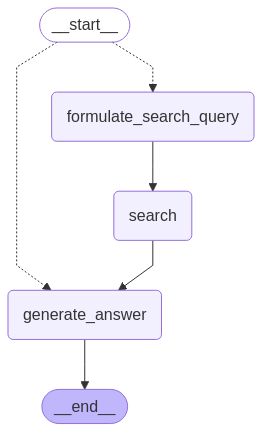

In [92]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [93]:
config = {"configurable": {"thread_id": "1"}}
user_input = "What are the best practices for model governance?"
res = graph.invoke({"messages": [{"role": "user", "content": user_input}], "input_validated": False}, config)

Search query:  model governance best practices financial services risk management


In [94]:
rprint(res["messages"][-1].content)

Based on the provided context, here are the best practices for model governance:

1. Board and Senior Management Oversight
- Establish a bank-wide approach to model risk management
- Create a strong model risk management framework that fits into broader organizational risk management
- Understand model risk at both individual and aggregate levels
- Set standards for model development, implementation, use, and validation
- Ensure model risk is within organizational tolerance

2. Governance Framework Components
- Develop clear policies and procedures
- Implement a system of internal controls
- Maintain an internal audit process
- Create and maintain a model inventory
- Ensure comprehensive documentation

3. Three Lines of Defense Approach
- Frontline units that create risk
- Independent risk management to assess risk
- Internal audit to provide independent assurance

4. Communication and Transparency
- Encourage effective communication among stakeholders
- Promote a culture that supports challenging risk analysis and model processes
- Enable transparent reporting on model risks

5. Change Management
- Implement robust change management processes
- Address changes in model development, personnel, policies, testing, IT systems, and regulatory requirements

6. Personnel Considerations
- Ensure personnel providing model risk challenge have:
  - Appropriate training and knowledge
  - Technical competence
  - Authority to recommend actions and escalate issues
  - Explicit authority and organizational support

7. Risk Appetite and Materiality
- Define risk appetite parameters
- Set targets for model accuracy
- Adjust governance complexity based on model usage and potential impact

These practices aim to create a comprehensive, adaptive, and robust model governance framework.

In [95]:
config = {"configurable": {"thread_id": "1"}}
user_input = "How fast is a cheetah?"
res = graph.invoke({"messages": [{"role": "user", "content": user_input}], "input_valid": False}, config)
rprint(res["messages"][-1].content)

I'm sorry but I cannot assist with that.

In [96]:
config = {"configurable": {"thread_id": "1"}}
user_input = "What are some example best practices for a credit risk model?"
res = graph.invoke({"messages": [{"role": "user", "content": user_input}], "input_valid": False}, config)
rprint(res["messages"][-1].content)

Search query:  credit risk model best practices governance


Based on the provided context, I can offer some general model risk management best practices that would apply to 
credit risk models, though the context does not specifically discuss credit risk models in detail:

1. Governance and Oversight:
- Establish a strong model risk management framework at the board and senior management level
- Ensure board oversight and regular reporting on model risks
- Define clear roles, responsibilities, and expertise for model stakeholders

2. Policy and Control Practices:
- Develop comprehensive policies that cover:
  - Model development, implementation, and validation standards
  - Model approval and change management processes
  - Data quality and relevance controls
  - Limits on model use
  - Documentation requirements

3. Model Development and Validation:
- Maintain detailed understanding of model capabilities and limitations
- Develop targets for model accuracy
- Conduct rigorous testing and analysis
- Establish standards for acceptable discrepancies
- Perform validation before production and ongoing validation

4. Risk Management:
- Understand model risks at both individual and aggregate levels
- Define risk appetite and parameters for model exceptions
- Ensure fair lending considerations to prevent discrimination

5. Contingency Planning:
- Develop backup plans in case of vendor model discontinuation
- Maintain in-house knowledge of model mechanics

These practices aim to ensure robust, transparent, and controlled model risk management.

In [97]:
config = {"configurable": {"thread_id": "1"}}
user_input = "How about for a fraud detection model?"
res = graph.invoke({"messages": [{"role": "user", "content": user_input}], "input_valid": False}, config)
rprint(res["messages"][-1].content)

Search query:  fraud detection model governance best practices


Based on the provided context, I can offer general guidance for model governance that would apply to a fraud 
detection model, but the text does not specifically address fraud detection models in detail. 

Key principles that would apply to a fraud detection model include:

1. Governance Framework
- Establish clear standards for model development, implementation, use, and validation
- Ensure board and senior management oversight
- Create policies that define roles, responsibilities, and expertise

2. Risk Management Considerations
- Assess model risk both for individual models and in aggregate
- Set targets for model accuracy
- Define acceptable limits and exceptions for the model's use
- Implement change management processes

3. Challenge and Oversight
- Ensure independent challenge of the model
- Maintain personnel with appropriate technical knowledge to critically analyze the model
- Document meeting minutes and model performance

4. Model Controls
- Establish controls for data quality and relevance
- Define approval and change management processes
- Set limits on model use
- Supplement model results with additional analysis
- Consider potential bias or discriminatory impacts

While these principles would apply broadly, the specific implementation would need to be tailored to the specific 
characteristics and risk profile of the fraud detection model.

### Clean up
You have reached the end of this workshop. Following cell will delete all created resources.


In [98]:
!rm -rf local_config.json section_doc_store_*.pkl section_vector_store_*.pkl

## Conclusion
In the above implementation of RAG based Question Answering and Conversational AI, we have explored the following concepts and how to implement them using the LangChain integrations for Amazon Bedrock and a local vector store:

- Loading documents and processing them into smaller chunks
- Creating a vector store using FAISS
- Generating embeddings with an embeddings model
- Searching the vector store to retrieve context relevant to the question
- Performing Generative Question Answering using foundation models
- Improving trust in our system by providing citations with every answer
- Preparing prompt templates to use as input to the LLM
- Storing conversation memory and providing the history as context to the LLM

### Next steps
- Experiment with different vector stores
- Leverage various text and embedding models available through Amazon Bedrock to see alternate outputs
- Explore options such as persistent storage of embeddings and document chunks
- Use Amazon Bedrock Knowledge Bases, a fully managed RAG capability with built-in session context management

# Thank You